In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from pprint import pprint
from datetime import datetime
import os
import csv

In [2]:
yr = 2019
fire_gdf = gpd.read_file(f'../outputs/geojson/clean/ca_fire_{yr}.geojson').set_crs(4326)
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,AGENCY,FIRE_NAME,geometry
0,2019-10-31,2019-11-05,14,Unknown/Unidentified,10042.46000,CCO,MARIA,"POLYGON ((-119.09030 34.29420, -119.09030 34.2..."
1,2019-10-30,2019-11-13,14,Unknown/Unidentified,1806.23400,CCO,EASY,"MULTIPOLYGON (((-118.83266 34.26544, -118.8326..."
2,2019-10-11,2019-10-13,14,Unknown/Unidentified,171.41830,CCO,OLIVAS,"MULTIPOLYGON (((-119.21632 34.23206, -119.2164..."
3,2019-07-14,2019-07-15,14,Unknown/Unidentified,131.31720,CCO,SOUTH,"POLYGON ((-118.97322 34.35087, -118.97288 34.3..."
4,2019-07-26,2019-07-27,14,Unknown/Unidentified,11.11976,CCO,POTRERO,"POLYGON ((-118.93609 34.15526, -118.93609 34.1..."


In [3]:
columns_to_drop = ['FIRE_NAME', 'AGENCY', 'geometry']
fire_gdf.drop(columns=columns_to_drop, inplace=True)

In [4]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES
0,2019-10-31,2019-11-05,14,Unknown/Unidentified,10042.46000
1,2019-10-30,2019-11-13,14,Unknown/Unidentified,1806.23400
2,2019-10-11,2019-10-13,14,Unknown/Unidentified,171.41830
3,2019-07-14,2019-07-15,14,Unknown/Unidentified,131.31720
4,2019-07-26,2019-07-27,14,Unknown/Unidentified,11.11976


In [5]:
fire_gdf.iloc[173,fire_gdf.columns.get_loc('ALARM_DATE')] = '2019-05-29'
fire_gdf.iloc[173,fire_gdf.columns.get_loc('CONT_DATE')] = '2019-05-29'

In [6]:
fire_gdf['CONT_DATE'] = pd.to_datetime(fire_gdf['CONT_DATE'])
fire_gdf['ALARM_DATE'] = pd.to_datetime(fire_gdf['ALARM_DATE'])
fire_gdf['Duration'] = fire_gdf['CONT_DATE'] - fire_gdf['ALARM_DATE']

In [7]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,2019-10-31,2019-11-05,14,Unknown/Unidentified,10042.46000,5 days
1,2019-10-30,2019-11-13,14,Unknown/Unidentified,1806.23400,14 days
2,2019-10-11,2019-10-13,14,Unknown/Unidentified,171.41830,2 days
3,2019-07-14,2019-07-15,14,Unknown/Unidentified,131.31720,1 days
4,2019-07-26,2019-07-27,14,Unknown/Unidentified,11.11976,1 days


In [8]:
average_duration = []
average_acres = []
cause_df = fire_gdf.sort_values(by='CAUSE_ID').reset_index()
def average_calc(i, df):
    test_df = df.loc[df['CAUSE_ID'] == i]
    days = []
    for d in test_df['Duration']:
        days.append(d.days)
    if len(days) != 0:
        average_d = round(sum(days)/len(days), 2)
    else:
        average_d = 0
    average_a = round(test_df['GIS_ACRES'].mean(),2)
    return average_d, average_a

for i in cause_df['CAUSE_ID'].unique():
    d, a = average_calc(i, cause_df)
    average_duration.append(d)
    average_acres.append(a)
cause_list = cause_df['CAUSE'].unique()
cause_df.head()

,index,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,229,2019-07-25,2019-11-21,1,Lightning,1875.98800,119 days
1,248,2019-09-05,2019-12-02,1,Lightning,5737.16000,88 days
2,102,2019-09-05,2019-09-06,1,Lightning,14.63054,1 days
3,267,2019-09-05,2019-09-12,1,Lightning,17.78256,7 days
4,269,2019-09-05,2019-12-03,1,Lightning,1339.59500,89 days


In [9]:
counts = cause_df.groupby('CAUSE_ID').size()
source_df = pd.DataFrame({'Causes' : cause_list, 
                          'Average Duration (days)' : average_duration, 
                          'Average GIS Acres' : average_acres,
                          'Number of Occurences (in the Year)' : counts})
source_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,34.93,957.76,58
2,Equipment Use,2.61,208.84,44
3,Smoking,14.67,8.26,3
4,Campfire,6.75,80.07,4
5,Debris,7.18,372.70,11
7,Arson,5.38,269.48,16
8,Playing with fire,0.33,17.66,3
9,Miscellaneous,34.57,2577.46,28
10,Vehicle,1.32,351.21,28


In [10]:
source_clean_df = source_df.drop(index = [9,14], inplace = False)
source_clean_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,34.93,957.76,58
2,Equipment Use,2.61,208.84,44
3,Smoking,14.67,8.26,3
4,Campfire,6.75,80.07,4
5,Debris,7.18,372.70,11
7,Arson,5.38,269.48,16
8,Playing with fire,0.33,17.66,3
10,Vehicle,1.32,351.21,28
11,Powerline,1.91,3608.42,23


In [15]:
man_duration = 0
man_GIS_acres = 0
man_oc = 0
nat_duration = 0
nat_GIS_acres = 0
nat_oc = 0
for index, row in source_clean_df.iterrows():
    if row['Causes'] == 'Lightning':
        nat_duration += row['Average Duration (days)']
        nat_GIS_acres += row['Average GIS Acres']
        nat_oc += row['Number of Occurences (in the Year)']
    else:
        man_duration += row['Average Duration (days)'] 
        man_GIS_acres += row['Average GIS Acres']
        man_oc += row['Number of Occurences (in the Year)']

man_vs_nature_df = pd.DataFrame({'Causes':['Man-Made', 'Natural'], 
                                 'Average Duration (days)': [man_duration, nat_duration], 
                                 'Average GIS Acres': [man_GIS_acres, nat_GIS_acres],
                                 'Number of Occurences (in the Year)':[man_oc, nat_oc]
                                })
man_vs_nature_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
0,Man-Made,41.65,5023.30,136
1,Natural,34.93,957.76,58


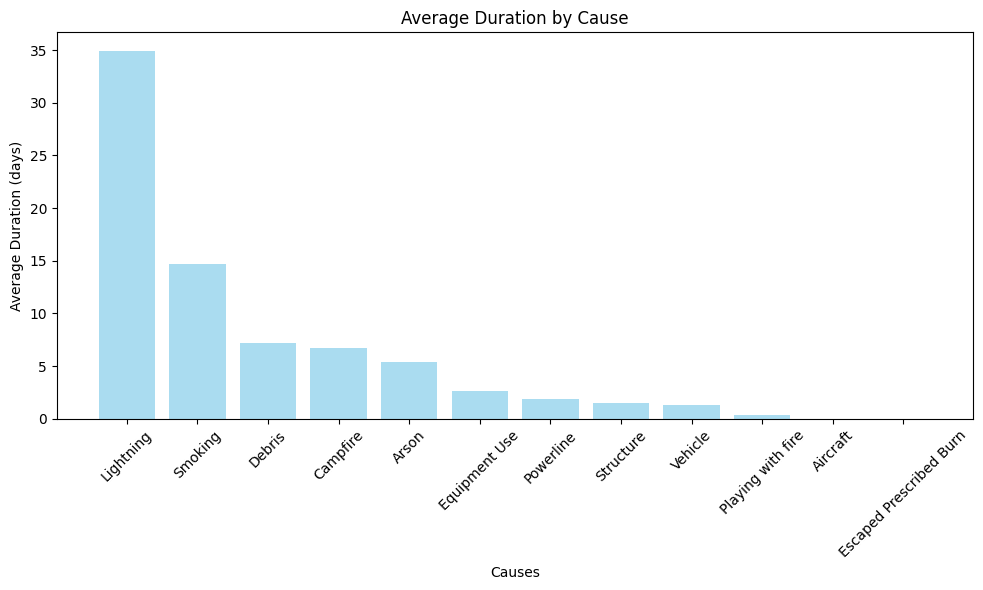

In [11]:
source_clean_df = source_clean_df.sort_values(by='Average Duration (days)', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

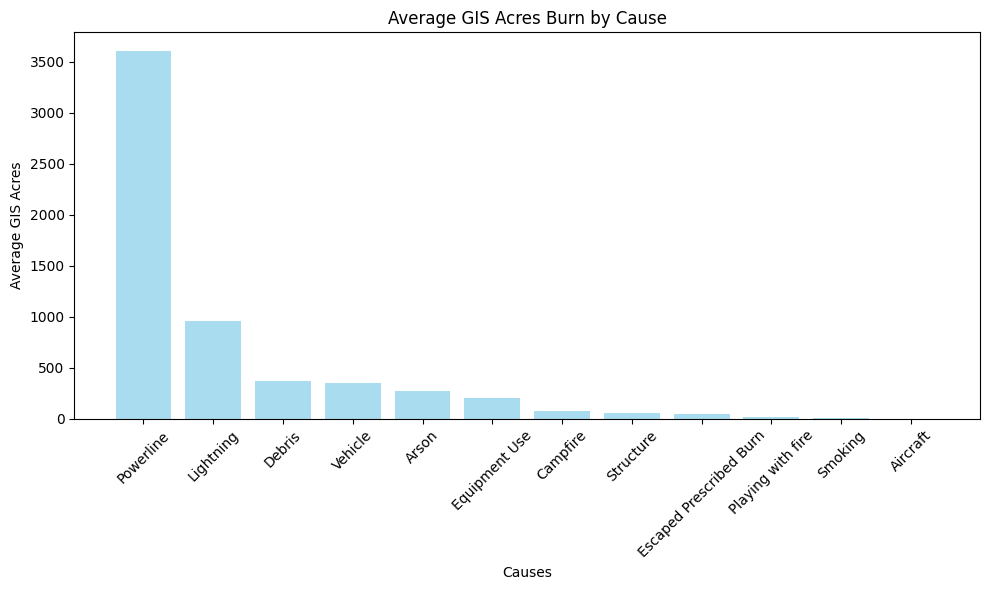

In [12]:
source_clean_df = source_clean_df.sort_values(by='Average GIS Acres', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

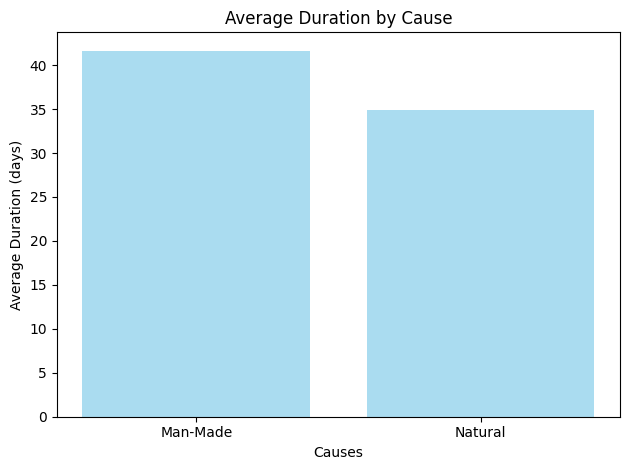

In [25]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.tight_layout()
plt.show()

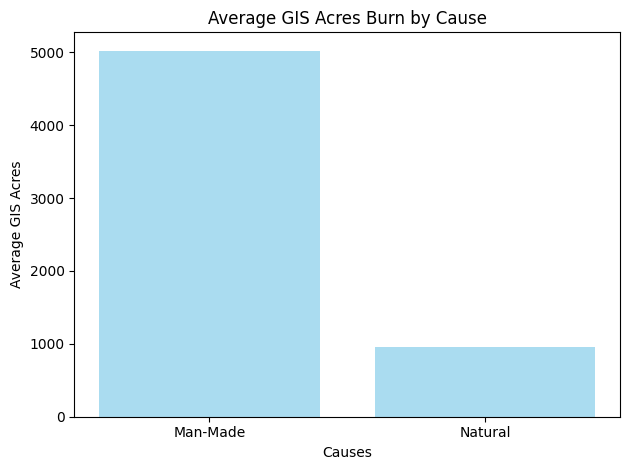

In [24]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.tight_layout()
plt.show()

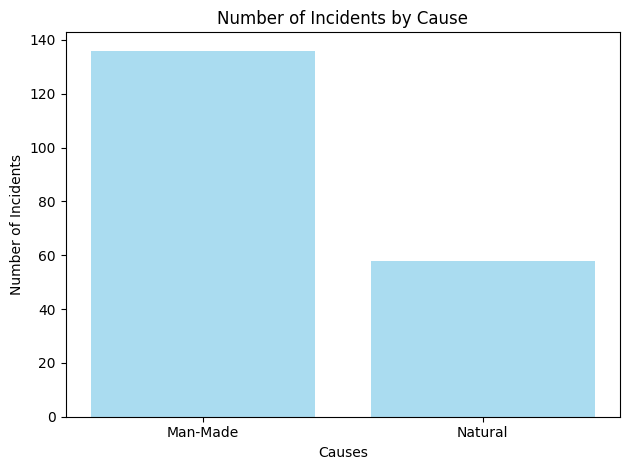

In [27]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Number of Occurences (in the Year)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents by Cause')

plt.tight_layout()
plt.show()